In [2]:
import matplotlib.pyplot as plt
import torch
from typing import List

import nnts
import nnts.data
import nnts.experiments
import nnts.models
import nnts.torch.data.preprocessing as preprocessing
import nnts.torch.models
import nnts.torch.models.trainers as trainers
import nnts.metrics
import nnts.torch.data
import nnts.torch.data.datasets
import nnts.loggers
import covs 

In [3]:
df_orig, metadata = nnts.data.load("hospital")
params = nnts.models.Hyperparams()
splitter = nnts.data.PandasSplitter()
model_name = "base-lstm"
PATH = f"results/{model_name}/{metadata.dataset}"

In [4]:
scenario_list: List[nnts.experiments.CovariateScenario] = []

# Add the baseline scenarios
for seed in [42, 43, 44, 45, 46]:
    scenario_list.append(
        nnts.experiments.CovariateScenario(metadata.prediction_length, error=0.0, covariates=0, seed=seed)
    )

# Models for full forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario_list.append( 
            nnts.experiments.CovariateScenario(
                metadata.prediction_length, error, covariates=covariates
            )
        )

# Models with short forecast horizon with covariates
for covariates in [1, 2, 3]:
    for error in covs.errors[metadata.dataset]:
        scenario = nnts.experiments.CovariateScenario(
            covariates, error, covariates=covariates
        )
        scenario_list.append(scenario)

In [5]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    trn_dl, val_dl, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.BaseLSTM(
        nnts.torch.models.LinearModel,
        params,
        preprocessing.masked_mean_abs_scaling,
        scenario.covariates + 1,
    )
    trner = trainers.TorchEpochTrainer(
        nnts.models.TrainerState(), 
        net, 
        params, 
        metadata, 
        f"{PATH}/{name}.pt",
        logger=logger
    )
    evaluator = trner.train(trn_dl, val_dl)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

BaseLSTM(
  (decoder): BaseLSTMDecoder(
    (rnn): LSTM(2, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 138.108154296875, 'valid_loss': 24.08831214904785, 'elapsed_time': 4.236770374933258}
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 35.50539016723633, 'valid_loss': 22.55615234375, 'elapsed_time': 4.321283207973465}
Artifact saved to results/base-lstm/hospital/cov-0-pearsn-0-pl-12-seed-42.pt
{'train_loss': 30.480056762695312, 'valid_loss': 19.364553451538086, 'elapsed_time': 4.203775958158076}
{'train_loss': 26.933717727661133, 'valid_loss': 19.4572696685791, 'elapsed_time': 4.315354458987713}
{'train_loss': 24.4988956451416, 'valid_los

In [6]:
scenario_list = [
    nnts.experiments.CovariateScenario(
        1, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        2, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
    nnts.experiments.CovariateScenario(
        3, 0, conts=[], pearson=1, noise=0, covariates=0
    ),
]

In [7]:
for scenario in scenario_list:
    nnts.torch.data.datasets.seed_everything(scenario.seed)
    df, scenario = covs.prepare(df_orig.copy(), scenario)
    split_data = splitter.split(df, metadata)
    _, _, test_dl = nnts.data.map_to_dataloaders(
        split_data,
        metadata,
        scenario,
        params,
        nnts.torch.data.TorchTimeseriesDataLoaderFactory(),
    )
    name = f"cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{str(scenario.prediction_length)}-seed-{scenario.seed}"
    logger = nnts.loggers.ProjectRun(
        nnts.loggers.JsonFileHandler(
            path=PATH, filename=f"{name}.json"
        ),
        #nnts.loggers.PrintHandler(),
        project=f"{model_name}-{metadata.dataset}",
        run=name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
    )

    net = nnts.torch.models.BaseLSTM(
    nnts.torch.models.LinearModel,
    params,
    preprocessing.masked_mean_abs_scaling,
    1,
)
    best_state_dict = torch.load(
        f"{PATH}/cov-{scenario.covariates}-pearsn-{str(round(scenario.pearson, 2))}-pl-{metadata.prediction_length}-seed-{scenario.seed}.pt"
    )
    net.load_state_dict(best_state_dict)
    evaluator = nnts.torch.models.trainers.TorchEvaluator(net)
    y_hat, y  = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, metadata.freq, metadata.seasonality
    )
    logger.log(test_metrics)
    logger.finish()

{'mse': 1115.1079, 'mae': 14.902524948120117, 'mape': 0.18814895, 'smape': 0.16558897495269775, 'abs_error': 11430.236, 'mase': 0.03246316, 'rmse': 14.902524948120117}
Run cov-0-pearsn-0-pl-1-seed-42 finished
{'mse': 1798.6467, 'mae': 16.798093795776367, 'mape': 0.2096224, 'smape': 0.17737743258476257, 'abs_error': 25768.277, 'mase': 0.037820965, 'rmse': 18.37063980102539}
Run cov-0-pearsn-0-pl-2-seed-42 finished
{'mse': 2071.1692, 'mae': 18.056324005126953, 'mape': 0.20508415, 'smape': 0.17921411991119385, 'abs_error': 41547.6, 'mase': 0.039189123, 'rmse': 20.75882339477539}
Run cov-0-pearsn-0-pl-3-seed-42 finished


In [8]:
csv_aggregator = covs.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

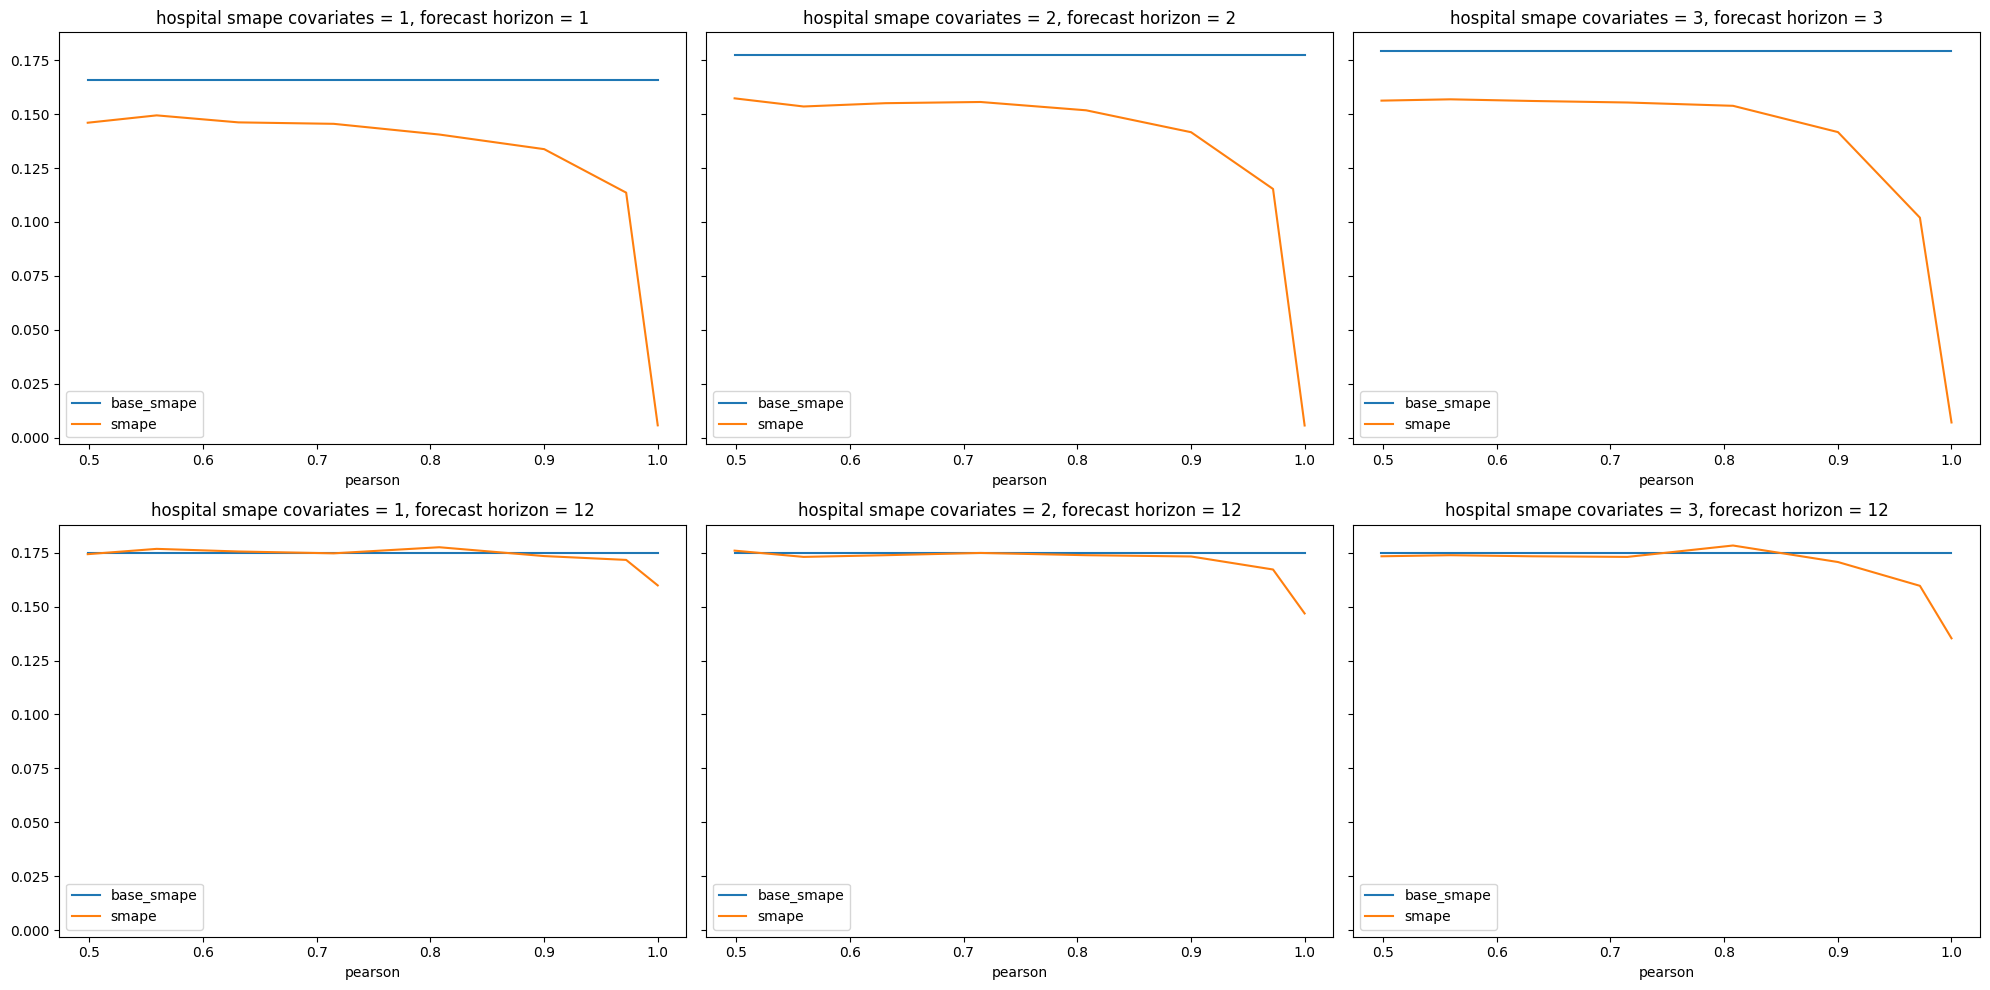

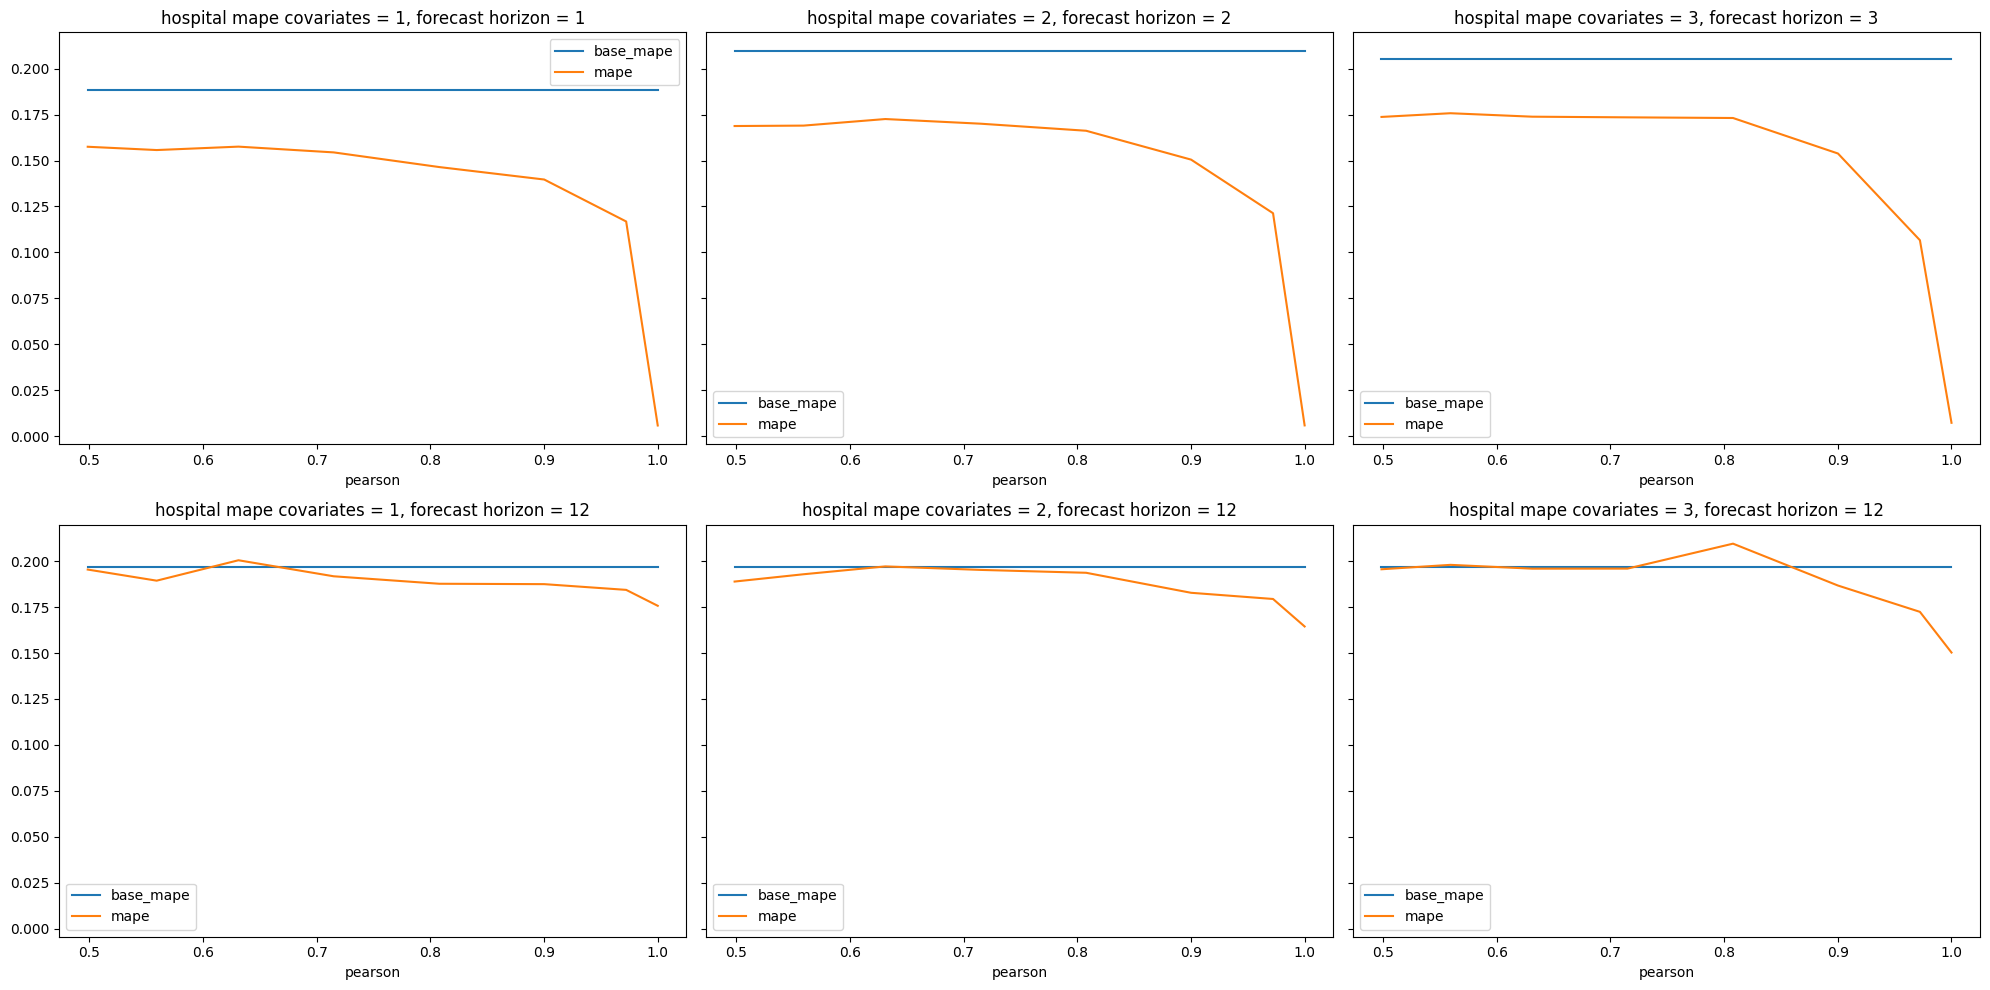

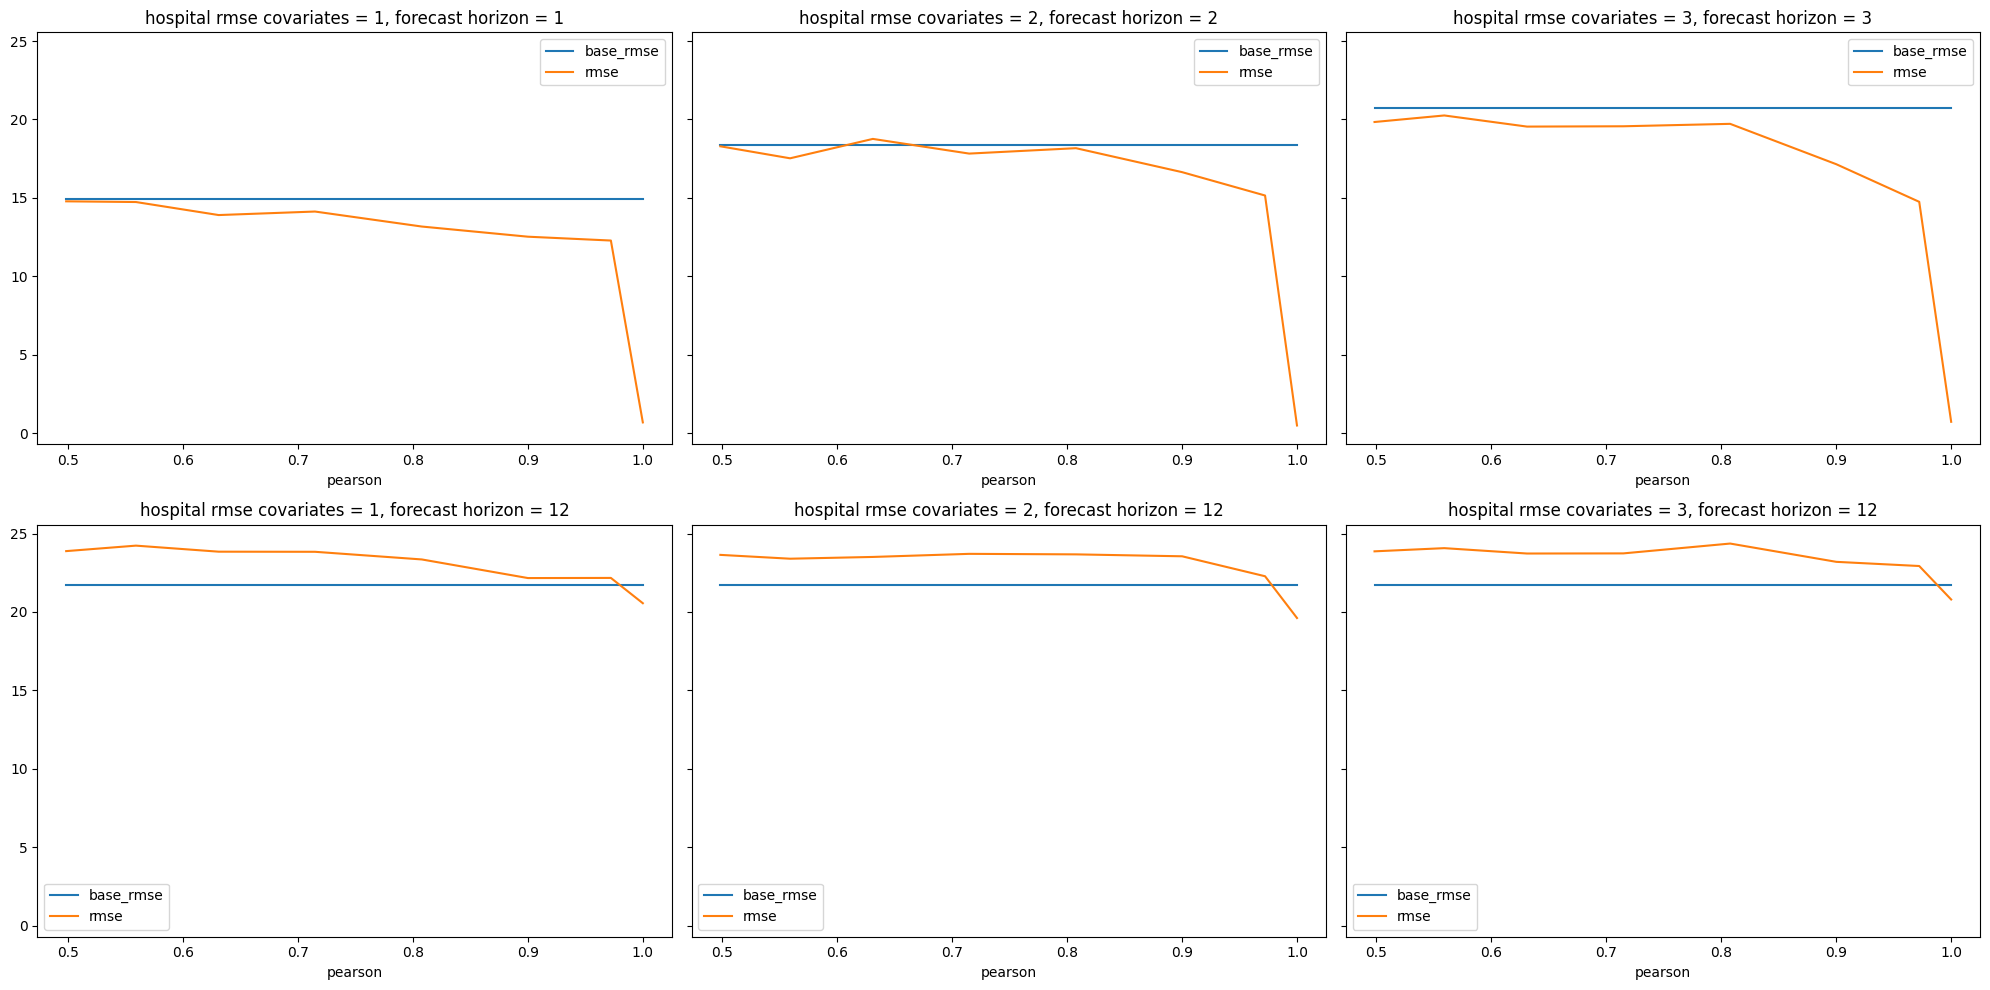

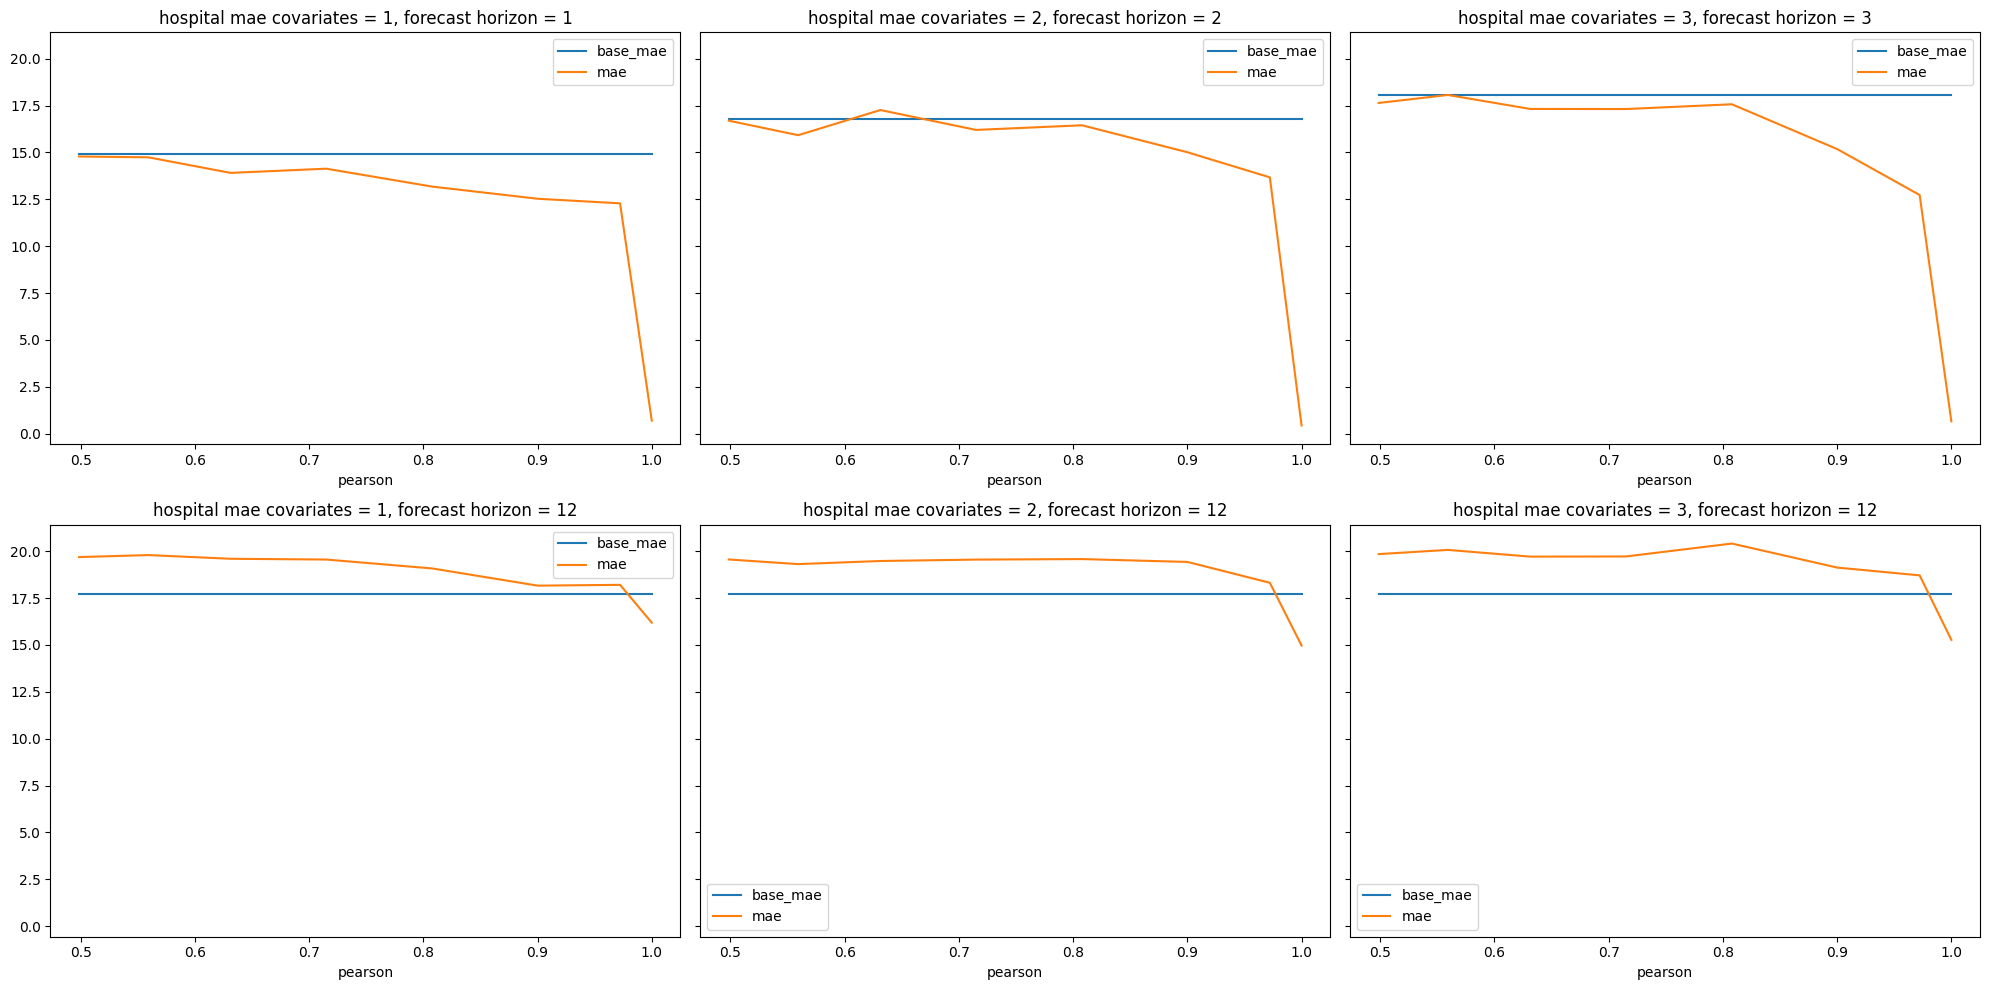

In [10]:
#results = pd.read_csv(f"{PATH}/results.csv")

for metric in ["smape", "mape", "rmse", "mae"]:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharey=True)
    covs.get_chart_data(results, 1, 1, metric).plot(
        kind="line",
        ax=axes[0, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = 1",
    )
    covs.get_chart_data(results, 2, 2, metric).plot(
        kind="line",
        ax=axes[0, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = 2",
    )
    covs.get_chart_data(results, 3, 3, metric).plot(
        kind="line",
        ax=axes[0, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = 3",
    )
    covs.get_chart_data(results, metadata.prediction_length, 1, metric).plot(
        kind="line",
        ax=axes[1, 0],
        title=f"{metadata.dataset} {metric} covariates = 1, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 2, metric).plot(
        kind="line",
        ax=axes[1, 1],
        title=f"{metadata.dataset} {metric} covariates = 2, forecast horizon = {metadata.prediction_length}",
    )
    covs.get_chart_data(results, metadata.prediction_length, 3, metric).plot(
        kind="line",
        ax=axes[1, 2],
        title=f"{metadata.dataset} {metric} covariates = 3, forecast horizon = {metadata.prediction_length}",
    )
    fig.tight_layout()
    fig.savefig(f"{PATH}/{metric}.png")

/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["y_hat"][-prediction_length:] = y_hat[i].squeeze()
/var/folders/8w/2dpk8lsx6hl861tqrs31bxb80000gn/T/ipykernel_11393/2584033428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

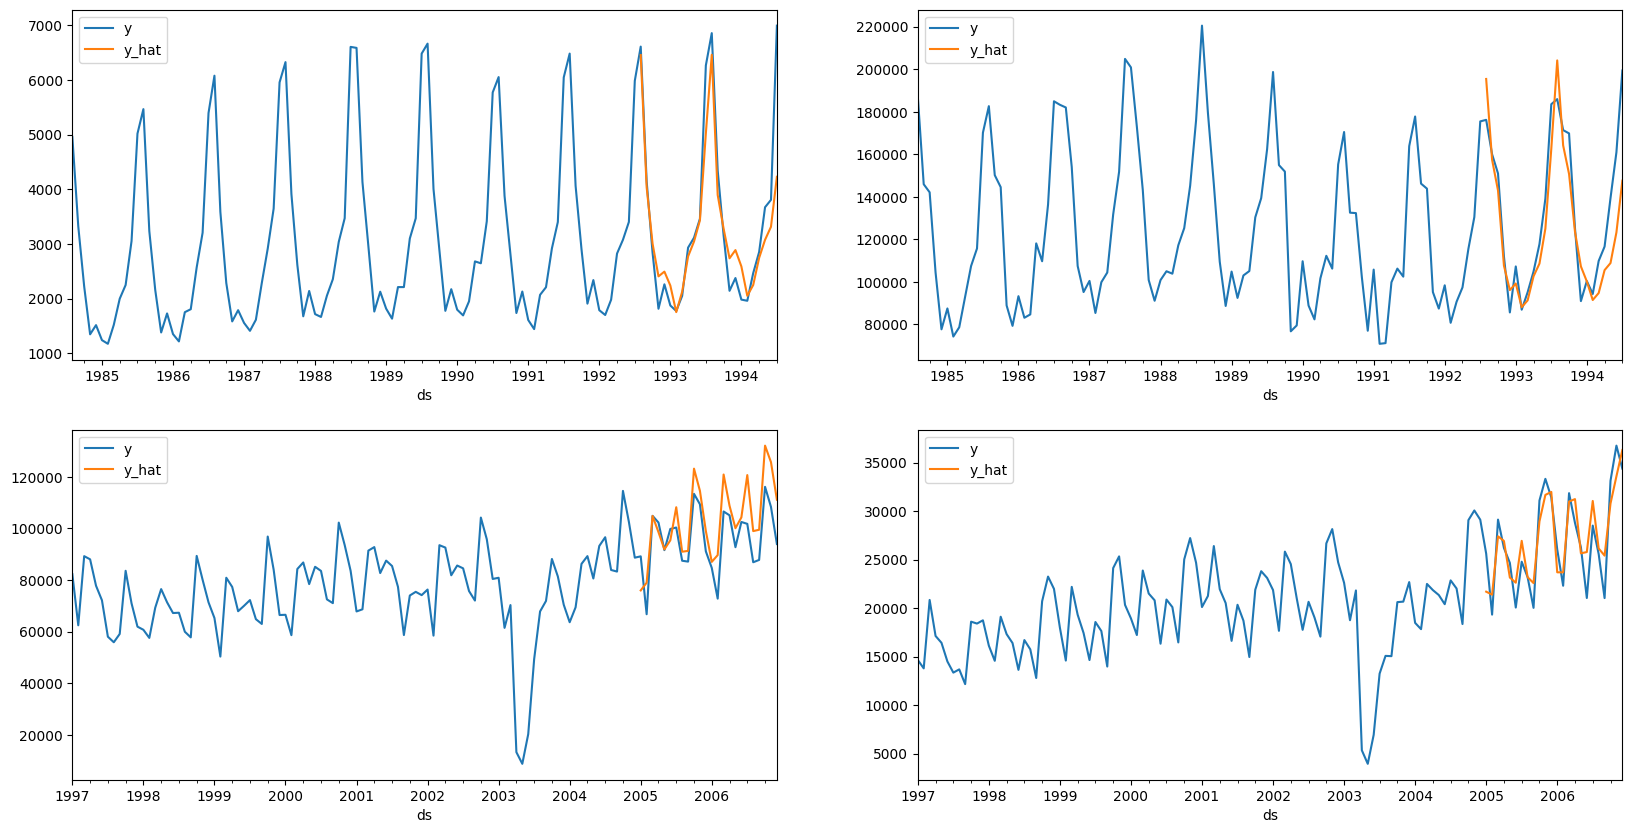

In [6]:
df_list = covs.add_y_hat(df, y_hat, scenario.prediction_length)
sample_preds = covs.plot(df_list, scenario.prediction_length)

In [14]:
results.loc[(results['covariates']==0) & (results['prediction_length']==metadata.prediction_length),['smape', 'mape', 'rmse', 'mae']].mean()

smape     0.175206
mape      0.193397
rmse     22.033822
mae      18.025483
dtype: float64